# Algorithms for Massive Data
# Project - Plant Leaves Recognizer
# David Fernandez - 988346

The task is to implement a deep-learning-based system classifying pictures of leaves according to the twelve types of plants

In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import array
from numpy import argmax
import seaborn as sns
import random
import cv2
import os
import pickle
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from keras.layers import PReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import graphviz
import pydot
import visualkeras
from PIL import ImageFont

In [31]:
#download data from Kaggle
import zipfile
import os

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

path = "D:\\Data\\"

os.environ['KAGGLE_USERNAME'] = "davidheilbron"
os.environ['KAGGLE_KEY'] = "60686e2d39aaab30b0ba19230091fcbe"
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification -p $path



  0%|          | 0.00/6.56G [00:00<?, ?B/s]
  0%|          | 3.00M/6.56G [00:00<03:51, 30.4MB/s]
  0%|          | 6.00M/6.56G [00:00<05:13, 22.4MB/s]
  0%|          | 10.0M/6.56G [00:00<04:08, 28.3MB/s]
  0%|          | 13.0M/6.56G [00:00<06:52, 17.0MB/s]
  0%|          | 17.0M/6.56G [00:01<07:45, 15.1MB/s]
  0%|          | 25.0M/6.56G [00:01<06:31, 17.9MB/s]
  0%|          | 33.0M/6.56G [00:01<06:13, 18.8MB/s]
  1%|          | 41.0M/6.56G [00:02<05:41, 20.5MB/s]
  1%|          | 49.0M/6.56G [00:02<05:23, 21.6MB/s]
  1%|          | 57.0M/6.56G [00:03<06:19, 18.4MB/s]
  1%|          | 65.0M/6.56G [00:03<05:44, 20.2MB/s]
  1%|1         | 73.0M/6.56G [00:03<05:25, 21.4MB/s]
  1%|1         | 81.0M/6.56G [00:04<05:23, 21.5MB/s]
  1%|1         | 89.0M/6.56G [00:04<05:53, 19.6MB/s]
  1%|1         | 97.0M/6.56G [00:04<05:17, 21.9MB/s]
  2%|1         | 105M/6.56G [00:05<05:04, 22.7MB/s] 
  2%|1         | 113M/6.56G [00:06<07:23, 15.6MB/s]
  2%|1         | 121M/6.56G [00:06<06:32, 17.6MB/s]
  2

In [ ]:
# unzip data
with zipfile.ZipFile(os.path.join(path, 'plant-leaves-for-image-classification.zip'), 'r') as zip_ref:
    zip_ref.extractall(path)

In [4]:
#set seed
seed(2023)
tf.random.set_seed(2023)

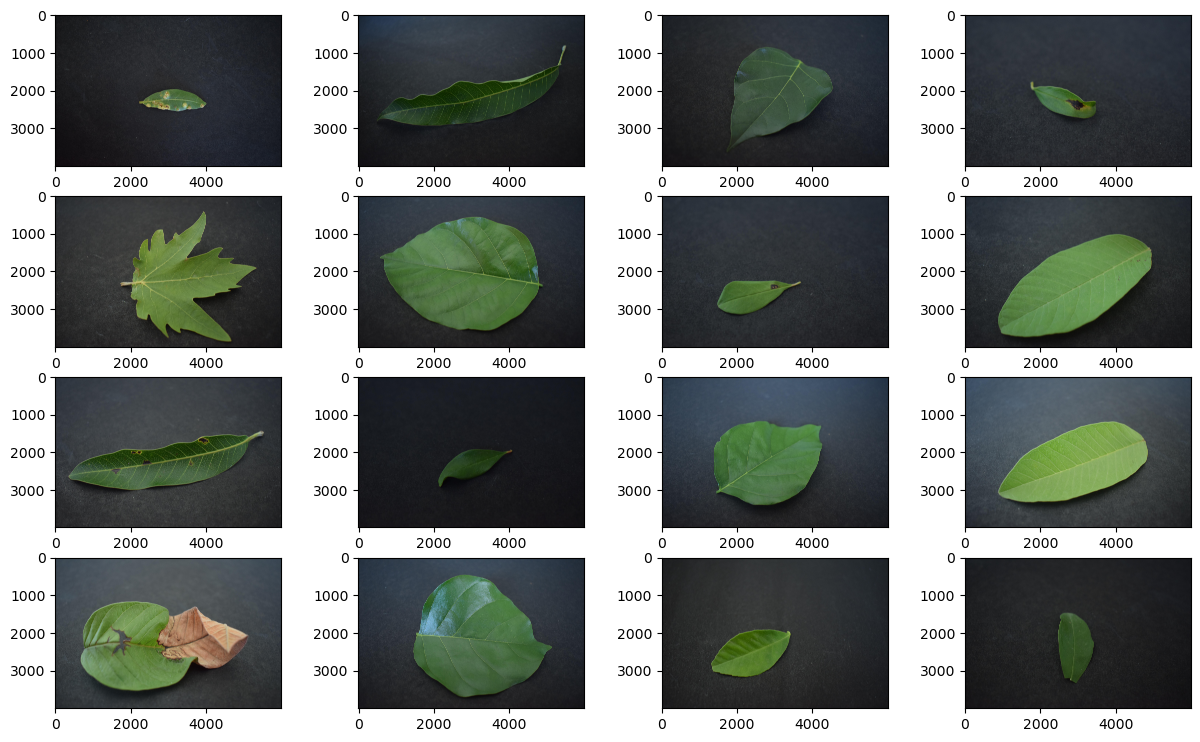

In [5]:
#show random images from training dataset
import random
from PIL import Image
from skimage.io import imread

path = r"D:\\Data\\Plants_2\\train"

images = []
for folder in os.listdir(path):
  for image in os.listdir(path + '/' + folder):
    images.append(os.path.join(path, folder, image))
      
plt.figure(1, figsize=(15, 9))
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\sample.jpeg", dpi = 200)
plt.show()


In [6]:
#Total number of images on each parent folder

def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

path = r"D:\\Data\\Plants_2\\images to predict"
num_files = count_files(path)
print("Total number of images in images to predict", num_files)

path = r"D:\\Data\\Plants_2\\test"
num_files = count_files(path)
print("Total number of images in test", num_files)

path = r"D:\\Data\\Plants_2\\train"
num_files = count_files(path)
print("Total number of images in train", num_files)

path = r"D:\\Data\\Plants_2\\valid"
num_files = count_files(path)
print("Total number of images in valid", num_files)


Total number of images in images to predict 8
Total number of images in test 110
Total number of images in train 4274
Total number of images in valid 110


In [7]:
#How many files do we have on the test folder?

path = r"D:\\Data\\Plants_2\\test"
image_counts = {}

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

Folder D:\\Data\\Plants_2\\test\Alstonia Scholaris contains 10 images.
Folder D:\\Data\\Plants_2\\test\Arjun contains 10 images.
Folder D:\\Data\\Plants_2\\test\Basil contains 10 images.
Folder D:\\Data\\Plants_2\\test\Chinar contains 10 images.
Folder D:\\Data\\Plants_2\\test\Gauva contains 10 images.
Folder D:\\Data\\Plants_2\\test\Jamun contains 10 images.
Folder D:\\Data\\Plants_2\\test\Jatropha contains 10 images.
Folder D:\\Data\\Plants_2\\test\Lemon contains 10 images.
Folder D:\\Data\\Plants_2\\test\Mango contains 10 images.
Folder D:\\Data\\Plants_2\\test\Pomegranate contains 10 images.
Folder D:\\Data\\Plants_2\\test\Pongamia Pinnata contains 10 images.


In [113]:
# fix Basil diseaded folder name

old_folder_name = r"D:\\Data\\Plants_2\\test\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\test\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

old_folder_name = r"D:\\Data\\Plants_2\\train\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\train\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

old_folder_name = r"D:\\Data\\Plants_2\\valid\\Bael diseased (P4b)"
new_folder_name = r"D:\\Data\\Plants_2\\valid\\Basil diseased (P4b)"

os.rename(old_folder_name, new_folder_name)

In [8]:
#How many files do we have on the training folder?

path = r"D:\\Data\\Plants_2\\train"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)


Folder D:\\Data\\Plants_2\\train\Alstonia Scholaris contains 412 images.
Folder D:\\Data\\Plants_2\\train\Arjun contains 432 images.
Folder D:\\Data\\Plants_2\\train\Basil contains 244 images.
Folder D:\\Data\\Plants_2\\train\Chinar contains 203 images.
Folder D:\\Data\\Plants_2\\train\Gauva contains 398 images.
Folder D:\\Data\\Plants_2\\train\Jamun contains 603 images.
Folder D:\\Data\\Plants_2\\train\Jatropha contains 237 images.
Folder D:\\Data\\Plants_2\\train\Lemon contains 216 images.
Folder D:\\Data\\Plants_2\\train\Mango contains 414 images.
Folder D:\\Data\\Plants_2\\train\Pomegranate contains 538 images.
Folder D:\\Data\\Plants_2\\train\Pongamia Pinnata contains 577 images.


In [9]:
#How many files do we have on the validation folder?

path = r"D:\\Data\\Plants_2\\valid"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

Folder D:\\Data\\Plants_2\\valid\Alstonia Scholaris contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Arjun contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Basil contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Chinar contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Gauva contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Jamun contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Jatropha contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Lemon contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Mango contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Pomegranate contains 10 images.
Folder D:\\Data\\Plants_2\\valid\Pongamia Pinnata contains 10 images.


# Pre processing of training dataset

In [ ]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)

    try:
        # mode of the folder
        mode = 0o777

        # Create folder
        os.mkdir(path, mode)
    except OSError as error:
        print(error)


In [117]:
#Merge folders of healthy and diseased plants into a single folder

# merge Alstonia Scholaris diseased and healthy into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Arjun folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Basil folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Chinar folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Gauva folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Jamun folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Jatropha folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Lemon folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Mango folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Pomegranate folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))


# merge Pongamia Pinnata folders into one single folder
current_folder = r"D:\\Data\\Plants_2\\train"

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [11]:
#set categories
directory = r"D:\Data\Plants_2\train"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

In [12]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [14]:
#check images size
print(len(data)) #check dataset size 
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

4274
200


In [47]:
#check data composition
print(data[0][0][199])

[[34 29 31]
 [30 27 29]
 [33 30 32]
 [32 30 30]
 [34 31 33]
 [35 32 34]
 [32 29 31]
 [37 34 36]
 [30 27 29]
 [34 31 33]
 [34 32 32]
 [33 30 32]
 [35 32 34]
 [36 33 35]
 [34 31 33]
 [35 32 34]
 [31 28 30]
 [33 30 32]
 [33 30 32]
 [39 34 36]
 [36 33 35]
 [36 34 34]
 [37 34 36]
 [40 37 39]
 [41 38 40]
 [36 33 35]
 [37 34 36]
 [36 33 35]
 [38 35 37]
 [38 35 37]
 [35 32 34]
 [39 36 38]
 [38 35 37]
 [39 36 38]
 [42 39 41]
 [40 37 39]
 [45 44 46]
 [40 39 41]
 [42 41 43]
 [42 41 43]
 [40 39 41]
 [40 39 41]
 [44 43 45]
 [40 39 41]
 [37 36 38]
 [38 37 39]
 [37 34 36]
 [43 40 42]
 [40 37 39]
 [39 36 38]
 [39 38 40]
 [42 39 41]
 [41 38 40]
 [45 42 44]
 [40 39 41]
 [41 38 40]
 [40 39 41]
 [45 42 44]
 [43 40 42]
 [41 38 40]
 [46 43 45]
 [45 42 44]
 [41 38 40]
 [47 44 46]
 [43 42 44]
 [40 39 41]
 [45 44 48]
 [43 42 44]
 [44 43 45]
 [43 42 44]
 [42 41 43]
 [42 41 45]
 [44 43 45]
 [42 41 45]
 [47 46 48]
 [50 49 51]
 [47 46 48]
 [45 44 46]
 [44 43 45]
 [45 44 46]
 [41 40 44]
 [41 40 44]
 [39 38 42]
 [38

In [19]:
data[random.randint(0,len(data))][0]

array([[[30, 25, 22],
        [33, 28, 25],
        [30, 25, 22],
        ...,
        [26, 21, 20],
        [26, 21, 20],
        [26, 21, 20]],

       [[31, 26, 23],
        [32, 27, 24],
        [30, 25, 22],
        ...,
        [29, 24, 21],
        [27, 22, 21],
        [23, 18, 17]],

       [[31, 26, 23],
        [28, 23, 20],
        [31, 26, 23],
        ...,
        [26, 21, 18],
        [26, 21, 18],
        [25, 20, 19]],

       ...,

       [[21, 16, 17],
        [23, 18, 19],
        [24, 19, 21],
        ...,
        [20, 18, 18],
        [20, 18, 18],
        [19, 17, 17]],

       [[21, 16, 17],
        [22, 17, 18],
        [23, 18, 20],
        ...,
        [19, 16, 18],
        [18, 16, 16],
        [17, 15, 15]],

       [[22, 17, 18],
        [23, 18, 19],
        [23, 18, 20],
        ...,
        [19, 16, 18],
        [18, 15, 17],
        [19, 17, 17]]], dtype=uint8)

In [48]:
#split features and labels in data
X_train = []
y_train = []

for features, labels in data:
    X_train.append(features)
    y_train.append(labels)
    
    
#transform data to np arrays
X_train=np.array(X_train)
y_train=np.array(y_train)

#check lenght of features and labels
print(len(X_train))
print(len(y_train))

#scale features for easier processing
X_train=X_train/255

#check shape
X_train.shape

#one hot encoding for y_train
b = np.zeros((y_train.size, y_train.max() + 1))
b[np.arange(y_train.size), y_train] = 1
y_train = b

y_train[random.randint(0,len(y_train))]
y_train.shape

4274
4274


(4274, 11)

In [82]:
#just in case - one hot encoding for y_train
values = array(categories)
print(values)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# invert one hot encoding
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['Alstonia Scholaris' 'Arjun' 'Basil' 'Chinar' 'Gauva' 'Jamun' 'Jatropha'
 'Lemon' 'Mango' 'Pomegranate' 'Pongamia Pinnata']


In [113]:
#save progress
pickle.dump(X_train, open(r'D:\Data\pkl\X_train.pkl', "wb"))
pickle.dump(y_train, open(r'D:\Data\pkl\y_train.pkl', "wb"))

# Pre processing of test dataset

In [ ]:
#merge diseased and healthy folders into one single folder for each category of plant 

current_folder = r"D:\\Data\\Plants_2\\test"


#merge Alstonia Scholaris diseased and healthy into one single folder

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Arjun folders into one single folder

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Basil folders into one single folder

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Chinar folders into one single folder

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Gauva folders into one single folder

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jamun folders into one single folder

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jatropha folders into one single folder

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Lemon folders into one single folder

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Mango folders into one single folder

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pomegranate folders into one single folder

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pongamia Pinnata folders into one single folder

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [114]:
#set categories
directory = r"D:\Data\Plants_2\test"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

#now, we need to merge the healty and diseased folders of each plant species

In [115]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [116]:
#check images size
print(len(data)) #check dataset size after dropping damaged images
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

110
200


In [117]:
#split features and labels in data
X_test = []
y_test = []

for features, labels in data:
    X_test.append(features)
    y_test.append(labels)
    
    
#transform data to np arrays
X_test=np.array(X_test)
y_test=np.array(y_test)

#check lenght of features and labels
print(len(X_test))
print(len(y_test))

#scale features for easier processing
X_test=X_test/255

#check shape
X_test.shape

#one hot encoding for y_test
b = np.zeros((y_test.size, y_test.max() + 1))
b[np.arange(y_test.size), y_test] = 1
y_test = b

y_test[random.randint(0,len(y_test))]
y_test.shape

110
110


(110, 11)

In [118]:
#save progress
pickle.dump(X_test, open(r'D:\Data\pkl\X_test.pkl', "wb"))
pickle.dump(y_test, open(r'D:\Data\pkl\y_test.pkl', "wb"))

# Pre processing of validation dataset

In [62]:
#merge diseased and healthy folders into one single folder for each category of plant 

current_folder = r"D:\\Data\\Plants_2\\valid"


#merge Alstonia Scholaris diseased and healthy into one single folder

# list of folders to be merged
list_dir = ['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Alstonia Scholaris"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)

os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Arjun folders into one single folder

# list of folders to be merged
list_dir = ['Arjun diseased (P1a)', 'Arjun healthy (P1b)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Arjun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Basil folders into one single folder

# list of folders to be merged
list_dir = ['Basil diseased (P4b)', 'Basil healthy (P8)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Basil"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Chinar folders into one single folder

# list of folders to be merged
list_dir = ['Chinar diseased (P11b)', 'Chinar healthy (P11a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Chinar"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Gauva folders into one single folder

# list of folders to be merged
list_dir = ['Gauva diseased (P3b)', 'Gauva healthy (P3a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Gauva"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jamun folders into one single folder

# list of folders to be merged
list_dir = ['Jamun diseased (P5b)', 'Jamun healthy (P5a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jamun"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Jatropha folders into one single folder

# list of folders to be merged
list_dir = ['Jatropha diseased (P6b)', 'Jatropha healthy (P6a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Jatropha"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Lemon folders into one single folder

# list of folders to be merged
list_dir = ['Lemon diseased (P10b)', 'Lemon healthy (P10a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Lemon"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Mango folders into one single folder

# list of folders to be merged
list_dir = ['Mango diseased (P0b)', 'Mango healthy (P0a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Mango"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pomegranate folders into one single folder

# list of folders to be merged
list_dir = ['Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pomegranate"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

# merge Pongamia Pinnata folders into one single folder

# list of folders to be merged
list_dir = ['Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']

# enumerate on list_dir to get the content of all the folders and store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "Pongamia Pinnata"

# merge_folder path = current_folder + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

    # loop through the contents of the list of folders
    for contents in content_list[sub_dir]:

        # make the path of the content to move
        path_to_content = sub_dir + "/" + contents

        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content)

        # move the file
        shutil.move(dir_to_move, merge_folder_path)
        
os.rmdir(os.path.join(current_folder, list_dir[0]))
os.rmdir(os.path.join(current_folder, list_dir[1]))

In [13]:
#set categories
directory = r"D:\Data\Plants_2\valid"
categories = ['Alstonia Scholaris', 'Arjun', 'Basil', 
              'Chinar', 'Gauva', 'Jamun', 'Jatropha', 
              'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']

#now, we need to merge the healty and diseased folders of each plant species

In [119]:
#resize images
img_size=200

data=[]

for category in categories:
    folder=os.path.join(directory, category)
    label=categories.index(category)
    for img in os.listdir(folder):
        img_path=os.path.join(folder, img)
        img_arr=cv2.imread(img_path)
        img_arr=cv2.resize(img_arr, (img_size, img_size))
        data.append([img_arr, label])

In [ ]:
#check images size
print(len(data)) #check dataset size after dropping damaged images
print(len(data[random.randint(0,len(data))][0])) #check if the size of a random image is 200

In [120]:
#split features and labels in data
X_valid = []
y_valid = []

for features, labels in data:
    X_valid.append(features)
    y_valid.append(labels)
    
    
#transform data to np arrays
X_valid=np.array(X_valid)
y_valid=np.array(y_valid)

#check lenght of features and labels
print(len(X_valid))
print(len(y_valid))

#scale features for easier processing
X_valid=X_valid/255

#check shape
X_valid.shape

#one hot encoding for y_valid
b = np.zeros((y_valid.size, y_valid.max() + 1))
b[np.arange(y_valid.size), y_valid] = 1
y_valid = b

y_valid[random.randint(0,len(y_valid))]
y_valid.shape

110
110


(110, 11)

In [121]:
#save progress
pickle.dump(X_valid, open(r'D:\Data\pkl\X_valid.pkl', "wb"))
pickle.dump(y_valid, open(r'D:\Data\pkl\y_valid.pkl', "wb"))

# Checkpoint - Load pickles

In [3]:
#load training data
X_train = pickle.load(open(r'D:\Data\pkl\X_train.pkl', "rb"))
y_train = pickle.load(open(r'D:\Data\pkl\y_train.pkl', "rb"))

In [4]:
#load test data
X_test = pickle.load(open(r'D:\Data\pkl\X_test.pkl', "rb"))
y_test = pickle.load(open(r'D:\Data\pkl\y_test.pkl', "rb"))

In [5]:
#load validation data
X_valid = pickle.load(open(r'D:\Data\pkl\X_valid.pkl', "rb"))
y_valid = pickle.load(open(r'D:\Data\pkl\y_valid.pkl', "rb"))

# Set Seed

In [2]:
#set seed in case it was not set before
seed(2023)
tf.random.set_seed(2023)

# Models and results

## Model 1

In [6]:
#def model 1

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [7]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [8]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_1', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [9]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.2187 - accuracy: 0.1809
Epoch 1: val_loss improved from inf to 2.18079, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 46s 332ms/step - loss: 2.2187 - accuracy: 0.1809 - val_loss: 2.1808 - val_accuracy: 0.2000
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 1.8771 - accuracy: 0.3079
Epoch 2: val_loss improved from 2.18079 to 1.89702, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 43s 319ms/step - loss: 1.8771 - accuracy: 0.3079 - val_loss: 1.8970 - val_accuracy: 0.3091
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 1.6100 - accuracy: 0.4041
Epoch 3: val_loss improved from 1.89702 to 1.77017, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 44s 326ms/step - loss: 1.6100 - accuracy: 0.4041 - val_loss: 1.7702 - val_accuracy: 0.2636
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 1.4845 - accuracy: 0.4380
Epoch 4: val_loss improved from 1.77017 to 1.57215, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 44s 325ms/step - loss: 1.4845 - accuracy: 0.4380 - val_loss: 1.5722 - val_accuracy: 0.3818
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 1.3262 - accuracy: 0.5204
Epoch 5: val_loss improved from 1.57215 to 1.32552, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 42s 314ms/step - loss: 1.3262 - accuracy: 0.5204 - val_loss: 1.3255 - val_accuracy: 0.4818
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 1.1407 - accuracy: 0.5997
Epoch 6: val_loss improved from 1.32552 to 1.18446, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 44s 331ms/step - loss: 1.1407 - accuracy: 0.5997 - val_loss: 1.1845 - val_accuracy: 0.5455
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 0.9547 - accuracy: 0.6713
Epoch 7: val_loss improved from 1.18446 to 1.07068, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 43s 322ms/step - loss: 0.9547 - accuracy: 0.6713 - val_loss: 1.0707 - val_accuracy: 0.5727
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.7164
Epoch 8: val_loss improved from 1.07068 to 0.99097, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 42s 317ms/step - loss: 0.8311 - accuracy: 0.7164 - val_loss: 0.9910 - val_accuracy: 0.6182
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 0.7771 - accuracy: 0.7333
Epoch 9: val_loss improved from 0.99097 to 0.74704, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 48s 357ms/step - loss: 0.7771 - accuracy: 0.7333 - val_loss: 0.7470 - val_accuracy: 0.6909
Epoch 10/50
134/134 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.7604
Epoch 10: val_loss improved from 0.74704 to 0.64671, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 47s 354ms/step - loss: 0.6859 - accuracy: 0.7604 - val_loss: 0.6467 - val_accuracy: 0.7727
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.7943
Epoch 11: val_loss did not improve from 0.64671
134/134 [==============================] - 43s 324ms/step - loss: 0.6080 - accuracy: 0.7943 - val_loss: 0.7984 - val_accuracy: 0.7000
Epoch 12/50
134/134 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.8060
Epoch 12: val_loss improved from 0.64671 to 0.61183, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 43s 320ms/step - loss: 0.5678 - accuracy: 0.8060 - val_loss: 0.6118 - val_accuracy: 0.7909
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.8255
Epoch 13: val_loss did not improve from 0.61183
134/134 [==============================] - 40s 298ms/step - loss: 0.5185 - accuracy: 0.8255 - val_loss: 0.6491 - val_accuracy: 0.7455
Epoch 14/50
134/134 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8479
Epoch 14: val_loss improved from 0.61183 to 0.56707, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 45s 338ms/step - loss: 0.4565 - accuracy: 0.8479 - val_loss: 0.5671 - val_accuracy: 0.8182
Epoch 15/50
134/134 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8601
Epoch 15: val_loss did not improve from 0.56707
134/134 [==============================] - 42s 313ms/step - loss: 0.4224 - accuracy: 0.8601 - val_loss: 0.7496 - val_accuracy: 0.7455
Epoch 16/50
134/134 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8697
Epoch 16: val_loss improved from 0.56707 to 0.47338, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 47s 351ms/step - loss: 0.3899 - accuracy: 0.8697 - val_loss: 0.4734 - val_accuracy: 0.8455
Epoch 17/50
134/134 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8898
Epoch 17: val_loss improved from 0.47338 to 0.39885, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 45s 333ms/step - loss: 0.3402 - accuracy: 0.8898 - val_loss: 0.3989 - val_accuracy: 0.8545
Epoch 18/50
134/134 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8889
Epoch 18: val_loss did not improve from 0.39885
134/134 [==============================] - 41s 306ms/step - loss: 0.3465 - accuracy: 0.8889 - val_loss: 0.4709 - val_accuracy: 0.8273
Epoch 19/50
134/134 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9099
Epoch 19: val_loss did not improve from 0.39885
134/134 [==============================] - 54s 402ms/step - loss: 0.2852 - accuracy: 0.9099 - val_loss: 0.4455 - val_accuracy: 0.8455
Epoch 20/50
134/134 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9233
Epoch 20: val_loss improved from 0.39885 to 0.39836, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 51s 380ms/step - loss: 0.2556 - accuracy: 0.9233 - val_loss: 0.3984 - val_accuracy: 0.8636
Epoch 21/50
134/134 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.9174
Epoch 21: val_loss did not improve from 0.39836
134/134 [==============================] - 42s 314ms/step - loss: 0.2561 - accuracy: 0.9174 - val_loss: 0.4602 - val_accuracy: 0.8091
Epoch 22/50
134/134 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9202
Epoch 22: val_loss did not improve from 0.39836
134/134 [==============================] - 40s 298ms/step - loss: 0.2410 - accuracy: 0.9202 - val_loss: 0.4306 - val_accuracy: 0.8909
Epoch 23/50
134/134 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9434
Epoch 23: val_loss did not improve from 0.39836
134/134 [==============================] - 40s 302ms/step - loss: 0.1852 - accuracy: 0.9434 - val_loss: 0.7365 - val_accuracy: 0.7909
Epoch 24/50
134/134 [========

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


134/134 [==============================] - 47s 353ms/step - loss: 0.1431 - accuracy: 0.9560 - val_loss: 0.3795 - val_accuracy: 0.8455
Epoch 27/50
134/134 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9504
Epoch 27: val_loss did not improve from 0.37951
4/4 [==============================] - 0s 71ms/step - loss: 0.4306 - accuracy: 0.8909
Validation Score:  [0.4306360185146332, 0.8909090757369995]




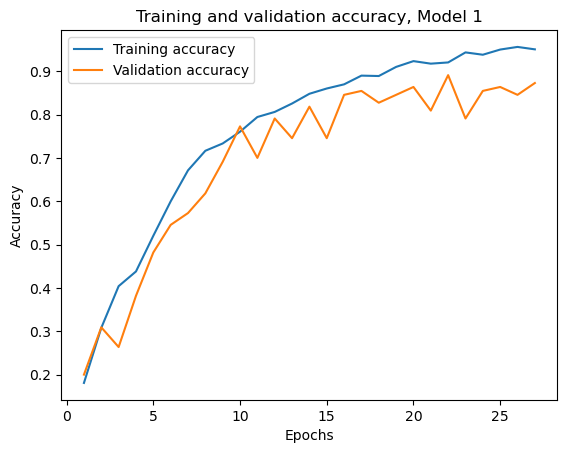

In [10]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_3.jpeg")

plt.show()

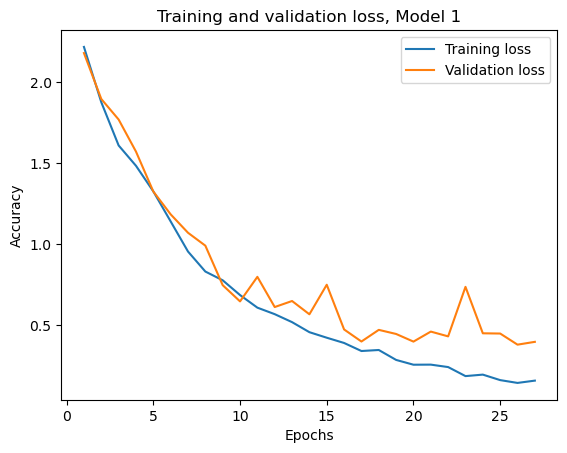

In [11]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model1_4.jpeg")

plt.show()

In [12]:
#average training loss
model_1_train_loss=[]
model_1_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_1_train_loss)) #0.400

0.6827515849360714


In [13]:
#average validation loss
model_1_val_loss=[]
model_1_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_1_val_loss)) #0.6496

0.8240711534464801


In [14]:
#Test model 1
model = load_model('model_1')

#testing loss and accuracy
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 61ms/step - loss: 0.3795 - accuracy: 0.8455


[0.37950795888900757, 0.8454545736312866]

In [15]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

4/4 [==============================] - 1s 56ms/step
[2.9938717e-04 4.2617521e-10 6.3753752e-08 9.9139334e-07 9.1921890e-01
 6.4041629e-02 4.2190572e-04 9.3693266e-08 1.9099714e-08 2.5156101e-11
 1.6016951e-02]
0.99999994


In [16]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 9,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  8,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  1,  6,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  9,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  8,  0],
       [ 0,  0,  0,  0,  1,  2,  2,  0,  0,  0,  5]], dtype=int64)

In [17]:
#precision and recall- test set

print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.91      1.00      0.95        10
           2       0.80      0.80      0.80        10
           3       0.75      0.60      0.67        10
           4       0.90      0.90      0.90        10
           5       0.83      1.00      0.91        10
           6       0.69      0.90      0.78        10
           7       0.75      0.90      0.82        10
           8       0.91      1.00      0.95        10
           9       1.00      0.80      0.89        10
          10       1.00      0.50      0.67        10

    accuracy                           0.85       110
   macro avg       0.86      0.85      0.84       110
weighted avg       0.86      0.85      0.84       110



## Model 2

Main changes with respect to Model 1: kernel initializer is now glorot normal instead of he uniform, padding is valid instead of same and a Dropout(0.2) layer is added after each max pooling layer

In [18]:
#def model 2

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
       
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='valid'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [19]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 99, 99, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 32)       

In [20]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_2', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [21]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 2.3093 - accuracy: 0.1516
Epoch 1: val_loss improved from inf to 2.35450, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 60s 434ms/step - loss: 2.3093 - accuracy: 0.1516 - val_loss: 2.3545 - val_accuracy: 0.1455
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 1.9909 - accuracy: 0.3353
Epoch 2: val_loss improved from 2.35450 to 2.18304, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 63s 470ms/step - loss: 1.9909 - accuracy: 0.3353 - val_loss: 2.1830 - val_accuracy: 0.2727
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 1.5979 - accuracy: 0.4560
Epoch 3: val_loss improved from 2.18304 to 1.67296, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 55s 411ms/step - loss: 1.5979 - accuracy: 0.4560 - val_loss: 1.6730 - val_accuracy: 0.4000
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.5693
Epoch 4: val_loss improved from 1.67296 to 1.42827, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 57s 427ms/step - loss: 1.2290 - accuracy: 0.5693 - val_loss: 1.4283 - val_accuracy: 0.4545
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.6369
Epoch 5: val_loss improved from 1.42827 to 1.13742, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 54s 406ms/step - loss: 1.0417 - accuracy: 0.6369 - val_loss: 1.1374 - val_accuracy: 0.6091
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6972
Epoch 6: val_loss improved from 1.13742 to 1.01016, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 58s 436ms/step - loss: 0.9056 - accuracy: 0.6972 - val_loss: 1.0102 - val_accuracy: 0.6455
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 0.7962 - accuracy: 0.7356
Epoch 7: val_loss improved from 1.01016 to 0.90512, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 54s 405ms/step - loss: 0.7962 - accuracy: 0.7356 - val_loss: 0.9051 - val_accuracy: 0.6818
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7819
Epoch 8: val_loss improved from 0.90512 to 0.74831, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 56s 417ms/step - loss: 0.6698 - accuracy: 0.7819 - val_loss: 0.7483 - val_accuracy: 0.7182
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.7939
Epoch 9: val_loss did not improve from 0.74831
134/134 [==============================] - 49s 365ms/step - loss: 0.6267 - accuracy: 0.7939 - val_loss: 0.8892 - val_accuracy: 0.6818
Epoch 10/50
134/134 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.8088
Epoch 10: val_loss improved from 0.74831 to 0.74027, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 56s 419ms/step - loss: 0.5904 - accuracy: 0.8088 - val_loss: 0.7403 - val_accuracy: 0.6909
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.8131
Epoch 11: val_loss did not improve from 0.74027
134/134 [==============================] - 50s 373ms/step - loss: 0.5477 - accuracy: 0.8131 - val_loss: 0.8092 - val_accuracy: 0.7273
Epoch 12/50
134/134 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.8320
Epoch 12: val_loss improved from 0.74027 to 0.70321, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 55s 408ms/step - loss: 0.5019 - accuracy: 0.8320 - val_loss: 0.7032 - val_accuracy: 0.7455
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.8451
Epoch 13: val_loss did not improve from 0.70321
134/134 [==============================] - 49s 366ms/step - loss: 0.4762 - accuracy: 0.8451 - val_loss: 0.7653 - val_accuracy: 0.7727
Epoch 14/50
134/134 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8479
Epoch 14: val_loss did not improve from 0.70321
134/134 [==============================] - 50s 377ms/step - loss: 0.4689 - accuracy: 0.8479 - val_loss: 0.7335 - val_accuracy: 0.7273
Epoch 15/50
134/134 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8500
Epoch 15: val_loss improved from 0.70321 to 0.65369, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 60s 452ms/step - loss: 0.4533 - accuracy: 0.8500 - val_loss: 0.6537 - val_accuracy: 0.7636
Epoch 16/50
134/134 [==============================] - ETA: 0s - loss: 0.4250 - accuracy: 0.8615
Epoch 16: val_loss did not improve from 0.65369
134/134 [==============================] - 49s 366ms/step - loss: 0.4250 - accuracy: 0.8615 - val_loss: 0.7572 - val_accuracy: 0.7000
Epoch 17/50
134/134 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8730
Epoch 17: val_loss improved from 0.65369 to 0.51178, saving model to model_2


INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


134/134 [==============================] - 56s 415ms/step - loss: 0.3893 - accuracy: 0.8730 - val_loss: 0.5118 - val_accuracy: 0.8545
Epoch 18/50
134/134 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8687
Epoch 18: val_loss did not improve from 0.51178
134/134 [==============================] - 49s 366ms/step - loss: 0.3905 - accuracy: 0.8687 - val_loss: 0.6502 - val_accuracy: 0.7364
Epoch 19/50
134/134 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8896
Epoch 19: val_loss did not improve from 0.51178
134/134 [==============================] - 49s 366ms/step - loss: 0.3450 - accuracy: 0.8896 - val_loss: 0.5409 - val_accuracy: 0.8000
Epoch 20/50
134/134 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8842
Epoch 20: val_loss did not improve from 0.51178
134/134 [==============================] - 50s 370ms/step - loss: 0.3495 - accuracy: 0.8842 - val_loss: 0.6563 - val_accuracy: 0.7727
Epoch 21/50
134/134 [========

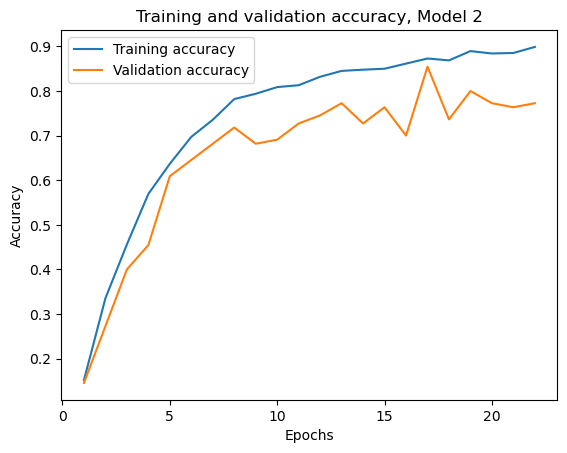

In [22]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_3.jpeg")

plt.show()

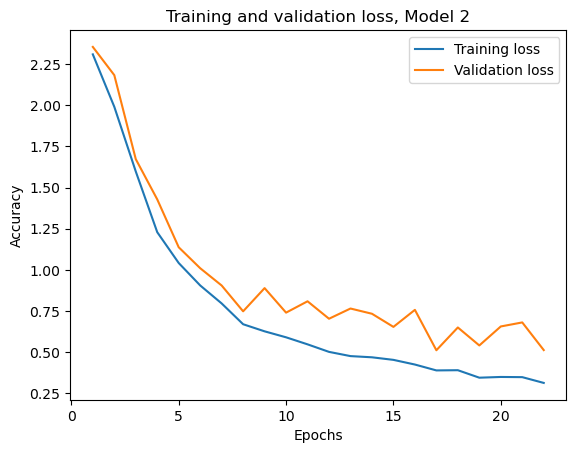

In [23]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model2_4.jpeg")

plt.show()

In [24]:
#training and validation loss
model_2_train_loss=[]
model_2_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_2_train_loss)) #0.8303

model_2_val_loss=[]
model_2_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_2_val_loss)) #0.9596

0.76210610026663
0.9565427276221189


In [25]:
#Test model 2
model = load_model('model_2')

#testing loss and accuracy
model.evaluate(X_test, y_test) #08454

4/4 [==============================] - 1s 54ms/step - loss: 0.5118 - accuracy: 0.8545


[0.5117773413658142, 0.8545454740524292]

In [26]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

4/4 [==============================] - 1s 76ms/step
[1.1366219e-01 2.5204287e-03 3.7756490e-05 2.4581244e-02 1.1494869e-02
 4.5276475e-01 7.1548549e-03 1.0910500e-03 8.5378510e-05 4.1462602e-07
 3.8660708e-01]
1.0


In [27]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  5,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  7,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  9,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  9]], dtype=int64)

In [28]:
#precision and recall- test set

print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.75      0.90      0.82        10
           2       1.00      0.90      0.95        10
           3       1.00      0.50      0.67        10
           4       0.88      0.70      0.78        10
           5       0.83      1.00      0.91        10
           6       0.59      1.00      0.74        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       0.89      0.80      0.84        10
          10       0.90      0.90      0.90        10

    accuracy                           0.85       110
   macro avg       0.89      0.85      0.85       110
weighted avg       0.89      0.85      0.85       110



## Model 3

Model 3 has the following changes with respect to model 2: Optimizer is Adam instead of SG. padding is 'same' again as in model 1, a fourth convolutional layer is added before the flatten layer

In [29]:
#def model 3

def create_model():
    model=Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
           
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='glorot_normal', padding='same'))
    model.add(MaxPooling2D((2,2)))
            
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(11, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001,
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             epsilon=1e-07,
                                                             amsgrad=False), metrics=['accuracy'])
    return model

#create model
model=create_model()

In [30]:
#visualize architecture
font = ImageFont.truetype("arial.ttf", 18)
visualkeras.layered_view(model, legend=True, font=font, 
                         to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_1.png")

#visualize architecture
tf.keras.utils.plot_model(model, 
                          to_file=r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_2.png",
                          show_shapes=False,
                          show_dtype=False,
                          show_layer_names=False,
                          rankdir="TB",
                          expand_nested=True,
                          dpi=92,
                          layer_range=None,
                          show_layer_activations=True)

#visualize architecture and trainable parameters
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 25, 25, 64)      

In [31]:
#define early stopping, callback and fit and evaluate function

#set early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, restore_best_weights=True)

#set model checkpoint callback, this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_3', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=32):
    model = None
    model = create_model()
    results = model.fit(t_x,
                        t_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        shuffle = True,
                        callbacks=[early_stopping, model_checkpoint],
                        validation_data=(val_x, val_y),)  
    print("Validation Score: ", model.evaluate(val_x, val_y))
    return results

In [32]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 
epochs=50
batch_size=32

print("Training: ")
model_history.append(fit_and_evaluate(X_train, X_valid, y_train, y_valid, epochs, batch_size))
print("======="*12, end="\n\n\n")

Training: 
Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 1.8753 - accuracy: 0.3451
Epoch 1: val_loss improved from inf to 1.44454, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 32s 229ms/step - loss: 1.8753 - accuracy: 0.3451 - val_loss: 1.4445 - val_accuracy: 0.4455
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 1.0306 - accuracy: 0.6593
Epoch 2: val_loss improved from 1.44454 to 0.89597, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 37s 277ms/step - loss: 1.0306 - accuracy: 0.6593 - val_loss: 0.8960 - val_accuracy: 0.6727
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.7754
Epoch 3: val_loss improved from 0.89597 to 0.65890, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 34s 251ms/step - loss: 0.6781 - accuracy: 0.7754 - val_loss: 0.6589 - val_accuracy: 0.7909
Epoch 4/50
134/134 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.8381
Epoch 4: val_loss did not improve from 0.65890
134/134 [==============================] - 32s 238ms/step - loss: 0.5067 - accuracy: 0.8381 - val_loss: 0.8363 - val_accuracy: 0.7364
Epoch 5/50
134/134 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8762
Epoch 5: val_loss improved from 0.65890 to 0.62297, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 33s 245ms/step - loss: 0.3904 - accuracy: 0.8762 - val_loss: 0.6230 - val_accuracy: 0.7636
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.9134
Epoch 6: val_loss improved from 0.62297 to 0.43596, saving model to model_3


INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 32s 241ms/step - loss: 0.2877 - accuracy: 0.9134 - val_loss: 0.4360 - val_accuracy: 0.8636
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9216
Epoch 7: val_loss did not improve from 0.43596
134/134 [==============================] - 31s 230ms/step - loss: 0.2359 - accuracy: 0.9216 - val_loss: 0.6857 - val_accuracy: 0.8182
Epoch 8/50
134/134 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9291
Epoch 8: val_loss did not improve from 0.43596
134/134 [==============================] - 33s 244ms/step - loss: 0.2154 - accuracy: 0.9291 - val_loss: 0.4410 - val_accuracy: 0.8636
Epoch 9/50
134/134 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9509
Epoch 9: val_loss did not improve from 0.43596
134/134 [==============================] - 31s 234ms/step - loss: 0.1615 - accuracy: 0.9509 - val_loss: 0.5101 - val_accuracy: 0.8545
Epoch 10/50
134/134 [==============

INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


134/134 [==============================] - 34s 255ms/step - loss: 0.1638 - accuracy: 0.9481 - val_loss: 0.3429 - val_accuracy: 0.8727
Epoch 11/50
134/134 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9705
Epoch 11: val_loss did not improve from 0.34290
134/134 [==============================] - 33s 247ms/step - loss: 0.0952 - accuracy: 0.9705 - val_loss: 0.5665 - val_accuracy: 0.8545
Epoch 12/50
134/134 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9738
Epoch 12: val_loss did not improve from 0.34290
134/134 [==============================] - 33s 246ms/step - loss: 0.0892 - accuracy: 0.9738 - val_loss: 0.3510 - val_accuracy: 0.9000
Epoch 13/50
134/134 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9567
Epoch 13: val_loss did not improve from 0.34290
134/134 [==============================] - 34s 255ms/step - loss: 0.1362 - accuracy: 0.9567 - val_loss: 0.6244 - val_accuracy: 0.8364
Epoch 14/50
134/134 [========

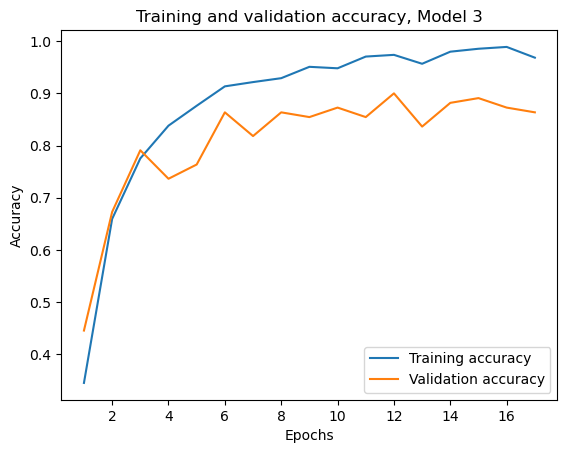

In [33]:
# learning curve
history_dict = model_history[0].history

# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_3.jpeg")

plt.show()

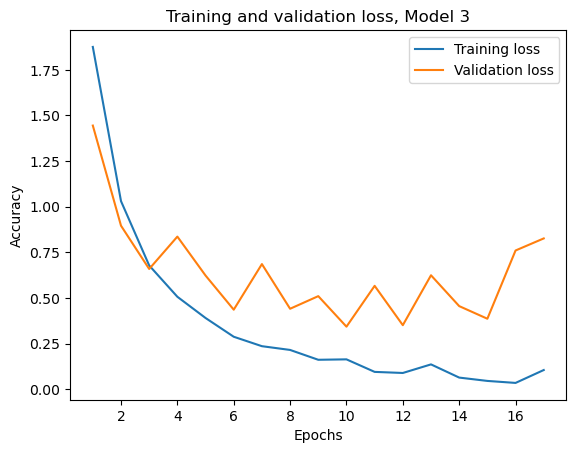

In [34]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss, Model 3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(r"C:\Users\Administrator\Documents\GitHub\Projects\Algorithms for Massive Datasets\Plots\model3_4.jpeg")

plt.show()

In [35]:
#training and validation loss
model_3_train_loss=[]
model_3_train_loss.append(np.mean(model_history[0].history['loss']))
print(np.mean(model_3_train_loss)) #0.3388

model_3_val_loss=[]
model_3_val_loss.append(np.mean(model_history[0].history['val_loss']))
print(np.mean(model_3_val_loss)) #0.72

0.3597509091829552
0.6379185283885282


In [36]:
#Test model 2
model = load_model('model_3')

#testing loss and accuracy
model.evaluate(X_test, y_test) #0.899

4/4 [==============================] - 0s 51ms/step - loss: 0.3429 - accuracy: 0.8727


[0.3428965210914612, 0.8727272748947144]

In [37]:
#random prediction - test set

preds = model.predict(X_test)
print(preds[109])
print(np.sum(preds[0]))

4/4 [==============================] - 0s 71ms/step
[9.8183416e-03 8.9441705e-04 3.2349554e-04 1.9369540e-05 5.8419597e-01
 1.7102741e-01 6.6902617e-04 1.9866370e-02 1.6098852e-07 2.2244761e-07
 2.1318519e-01]
1.0


In [38]:
#confusion matrix - test set

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  1,  8,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  9,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  0,  7,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  1,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  7]], dtype=int64)

In [39]:
#precision and recall- test set

print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))
plt.savefig('mytable.png')

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.89      0.80      0.84        10
           2       1.00      0.80      0.89        10
           3       0.82      0.90      0.86        10
           4       0.77      1.00      0.87        10
           5       0.83      1.00      0.91        10
           6       0.88      0.70      0.78        10
           7       1.00      0.80      0.89        10
           8       1.00      0.90      0.95        10
           9       0.83      1.00      0.91        10
          10       0.78      0.70      0.74        10

    accuracy                           0.87       110
   macro avg       0.88      0.87      0.87       110
weighted avg       0.88      0.87      0.87       110



<Figure size 640x480 with 0 Axes>